# 학습 관련 기술들
- 매개변수 갱신
- 가중치의 초깃값
- 배치 정규화
- 바른 학습을 위해
- 적절한 하이퍼파라미터 값 찾기

## 개요 

이번 장에서 설명하는 기법을 이용하면 학습의 효율과 정확도를 높일 수 있다.

## 매개변수 갱신
- 확률적 경사 하강법(SGD) 복습
- SGD의 단점
- 모멘텀
- AdaGrad
- Adam

### SGD
$ W \leftarrow W - \eta \frac{\partial L}{\partial W} $  
> $\frac{\partial L}{\partial W}$은 $W$에 대한 손실 함수의 기울기  
$\eta$는 학습률

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### 모멘텀 (Momentum)
왜 얘만 한글이지 외롭지 않게 괄호를 붙여주었다 ^^  

$v \leftarrow \alpha v - \eta \frac{\partial L}{\partial W}$   
$W \leftarrow W + v$  
아까랑 다른건 $v$가 생긴거고 이 $v$는 단순히 아까에서 $\alpha v$만 더해진거임
> $v$는 속도, $\alpha v$는 지면 마찰, 공기 저항과 같은 역할


In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, value in params.items():
                self.v[key] = np.zeros_like(value)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

### AdaGrad
Adaptive Gradient : 처음에는 크게 학습하다가 조금씩 작게 학습 = 학습률을 점차 줄여가는 방법  
매개변수 전체의 학습률 $\eta$를 감소시키는게 아니라 **각각의** 매개변수에 맞춘 학습률을 적용시킴  

$h \leftarrow h + \frac{\partial L}{\partial W} ⊙ \frac{\partial L}{\partial W}$  
$W \leftarrow W + \eta \frac{1}{\sqrt{h}}\frac{\partial L}{\partial W}$
> $h$는 기존 기울기 값을 계속 더해줌  
학습률에 $\frac{1}{\sqrt{h}}$을 곱해 학습률 조정 :**많이 움직인(크게 갱신된) 원소는 학습률이 낮아진다**, 즉 갱신 값의 움직임이 억제한다.  
⊙는 원소별 곱셈 `np.dot`이 아니라 단순한 스칼라 곱 `*`


In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, value in params.items():
                self.h[key] = np.zeros_like(value)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / np.sqrt(self.h[key] + 1e-7)            

### Adam
Adaptive momentum = AdaGrad + Momentum  
책에서는 http://arxiv.org/abs/1412.6980v8 의 논문을 참고하라하고 자세한 설명은 되어있지 않음  
$\beta_1$은 일차 모멘텀용 계수, 0.9가 좋음  
$\beta_2$는 이차 모멘텀용 계수, 0.999가 좋음

In [4]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


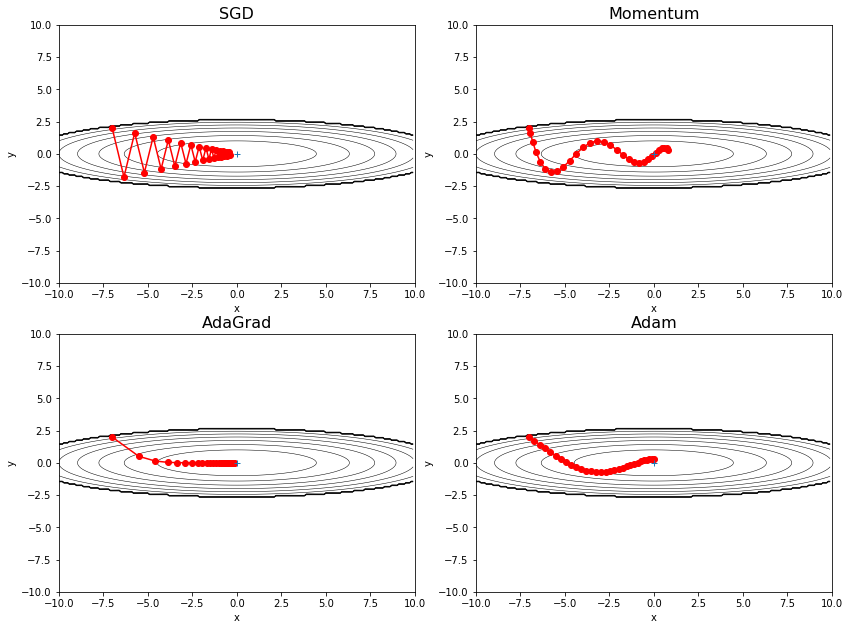

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

def draw(idx, key, x_history, y_history):
    xlim = 10
    ylim = 10
    x = np.arange(-xlim, xlim, 0.1)
    y = np.arange(-ylim, ylim, 0.1)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    ax = subplots[idx]
    ax.plot(x_history, y_history, 'o-', color="red")
    ax.contour(X, Y, Z, linewidths=0.5, colors='k')
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)
    ax.plot(0, 0, '+')
    ax.set_title(key, fontsize=16)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

init_pos = (-7.0, 2.0)
params = {
    "x": init_pos[0],
    "y": init_pos[1],
}

grads = {
    "x": 0,
    "y": 0,
}


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1, momentum=0.9)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

fig, subplots = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
subplots = subplots.flatten()
plt.tight_layout(pad=3, w_pad=3, h_pad=3)

for idx, key in enumerate(optimizers):
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
        
    draw(idx, key, x_history, y_history)
    
plt.show();

**SGD**와 **Adam**이 주로 쓰임

## 가중치의 초깃값
- Xavier 초깃값
- He 초깃값

## 배치 정규화

## 바른 학습을 위해
- 오버피팅이란
- 가중치 감소
- 드롭아웃
- 앙상블 학습

## 적절한 하이퍼파라미터 값 찾기
- 검증 데이터
- 하이퍼파라미터 최적화